Note: Une grande partie du code ci-dessous à été extrait ou inspiré de la ressource pour utiliser YAMNet. Crédit à https://www.tensorflow.org/hub/tutorials/yamnet et https://www.tensorflow.org/hub/tutorials/yamnet

# Préparation

In [ ]:
# Installation du bon TensorFlow
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

In [ ]:
# Importer librairies
from google.colab import files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [ ]:
# Fonctions utilitaires pour charger des fichiers audio et s'assurer que la fréquence d'échantillonnage est correcte
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
# Chargement de la données
file_path = '/content/annotations_test.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Mettre les données dans le bon format (tensorflow)
filenames = df['filename']
targets = df['target']
folds = df['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Split des données et mise en cache
cached_ds = main_ds.cache()
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# supprimer la colonne fold
remove_fold_column = lambda embedding, label, fold: (embedding, label)

test_ds = test_ds.map(remove_fold_column)

# mélange des données, batching, préchargement
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Instancier les noms des nouveaux labels
my_classes = ['0', '1','2','3','4']
map_class_to_id = {'0':0, '1':1,'2':2,'3':3,'4':4}

In [ ]:
# Chargement du modèle déjà entrainé
# !unzip yamnet_hawaii_synth_base.zip
!unzip Model_on_YAMNet_clean_and_noised.zip

Archive:  Model_on_YAMNet_clean_and_noised.zip
  inflating: Model_on_YAMNet_clean_and_noised/keras_metadata.pb  
  inflating: Model_on_YAMNet_clean_and_noised/variables/variables.index  
  inflating: Model_on_YAMNet_clean_and_noised/fingerprint.pb  
  inflating: Model_on_YAMNet_clean_and_noised/assets/yamnet_class_map.csv  
  inflating: Model_on_YAMNet_clean_and_noised/saved_model.pb  
  inflating: Model_on_YAMNet_clean_and_noised/variables/variables.data-00000-of-00001  


# Chargement du modèle déjà entrainé

In [ ]:
# Définir le path de YamNet après chargement
# saved_model_path = './yamnet_hawaii_synth_base'
saved_model_path = './Model_on_YAMNet_clean_and_noised'

In [ ]:
# Chargement du modèle sauvegardé avec TensorFlow
reloaded_model = tf.saved_model.load(saved_model_path)

# Inférence

In [ ]:
input_file = 'annotations_test.xlsx'
output_file = 'test_predictions_YAMNet_clean_and_noised.xlsx'

# Charger le fichier Excel
df = pd.read_excel(input_file)

# Ajouter une colonne pour la prédiction
df['Prediction'] = None

# Ajouter chaque prédiction de chaque instance dans le dataframe
for index, row in df.iterrows():
    try:
        # Charger la donnée audio depuis la source
        wav_path = '/content/' + str(row['filename'])

        # Obtenir le bon format défini précédemment
        wav_data = load_wav_16k_mono(wav_path)

        # Inférence avec le modèle
        pred_results = reloaded_model(wav_data)

        # Déterminer la classe prédite
        y_pred = my_classes[tf.math.argmax(pred_results)]

        # Ajouter le résultat dans le DataFrame
        df.at[index, 'Prediction'] = y_pred
    except Exception as e:
        print(f"Erreur")

# Sauvegarder le DataFrame avec les prédictions dans un nouveau fichier Excel
df.to_excel(output_file, index=False)

# Pour apprentissage actif au besoin

In [ ]:
# Téléchargement des résultats de l'inférence
files.download('test_predictions_YAMNet_clean_and_noised.xlsx')
!wget -O annotations_inference_v2.xlsx

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


# Évaluation

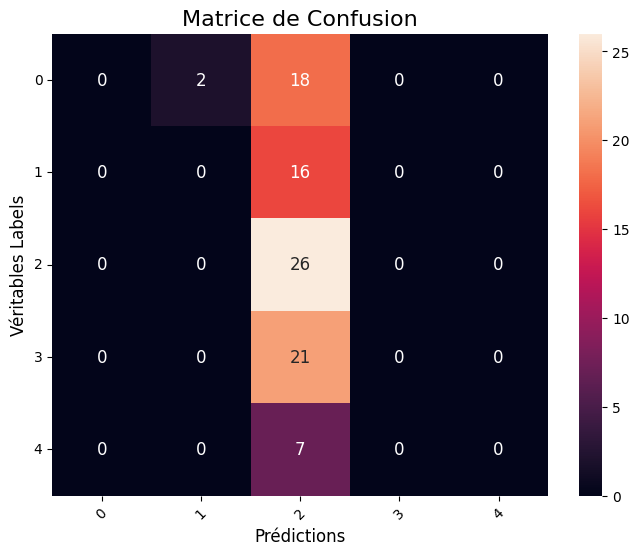

In [ ]:
file_path = 'test_predictions_YAMNet_clean_and_noised.xlsx'

# Charger les données depuis le fichier Excel
data = pd.read_excel(file_path)

# Extraire les données tests
data['Prediction_numeric'] = data['Prediction'].astype(int)
filtered_df = data[data['fold'] == 5]

# Extraire les colonnes 'label' et 'prediction'
true_labels = filtered_df['target']
predicted_labels = filtered_df['Prediction_numeric']

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=True, annot_kws={'size': 12})
plt.title('Matrice de Confusion', fontsize=16)
plt.xlabel('Prédictions', fontsize=12)
plt.ylabel('Véritables Labels', fontsize=12)

# Ajuster les labels
classes = range(len(conf_matrix))
plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=45)
plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)

plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Calcul de l'accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calcul des métriques micro
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='micro'
)

# Calcul des métriques macro
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    true_labels, predicted_labels, average='macro'
)

# Afficher les résultats
print(f"Accuracy: {accuracy:.2f}")

print("\n=== Micro Scores ===")
print(f"Micro Précision: {micro_precision:.2f}")
print(f"Micro Rappel: {micro_recall:.2f}")
print(f"Micro F1-Score: {micro_f1:.2f}")

print("\n=== Macro Scores ===")
print(f"Macro Précision: {macro_precision:.2f}")
print(f"Macro Rappel: {macro_recall:.2f}")
print(f"Macro F1-Score: {macro_f1:.2f}")

Accuracy: 0.29

=== Micro Scores ===
Micro Précision: 0.29
Micro Rappel: 0.29
Micro F1-Score: 0.29

=== Macro Scores ===
Macro Précision: 0.06
Macro Rappel: 0.20
Macro F1-Score: 0.09


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
